In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = "data/Train.csv"
test_data_path = "data/Test.csv"

data = pd.read_csv(data_path)
train_data = pd.read_csv(test_data_path)

data

,Unnamed: 0,id,text,sentiment
0,2,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive
...,...,...,...,...
21797,27896,805677750363095000,@hrtablaze the beginning of a dictatorship is ...,negative
21798,27897,637854813930196000,son idc anymore. i'm going by shawn tomorrow,neutral
21799,27898,802374277047656000,but remember the clinton foundation?? https://...,neutral
21800,27899,640441306494296000,"press: ""r u worried murray dominated his 3rd r...",neutral


In [38]:
data["sentiment"].value_counts()

neutral     12659
positive     5428
negative     3715
Name: sentiment, dtype: int64

,Unnamed: 0,id,text,sentiment,lengths
19727,25151,805651182035169000,for a long time no one considered the effect o...,negative,450
20485,26178,802384778607689000,green party presidential candidate jill stein ...,neutral,364


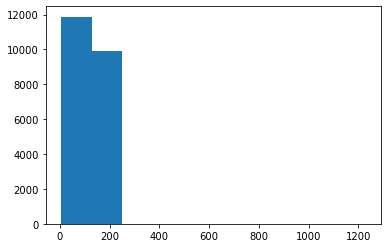

In [58]:
lengths = data["text"].apply(len)
plt.hist(lengths.values)
newdata = data.drop(np.argmax(lengths.values))

newdata["lengths"] = newdata["text"].apply(len)
newdata[newdata["lengths"] > 256]

450

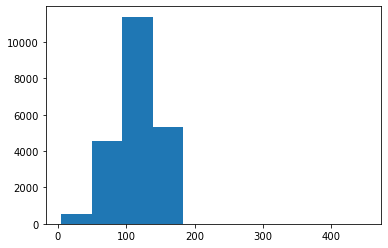

In [45]:
lengths = newdata["text"].apply(len)
plt.hist(lengths.values)
max(lengths.values)



In [1]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import torch
from torch import nn

In [2]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)
dataset = load_dataset("csv", data_files={"train": "data/Train.csv"},  encoding="ISO-8859-1")

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using custom data configuration default-9bf19e0c32f05296
Reusing dataset csv (C:\Users\Saurabh\.cache\huggingface\datasets\csv\default-9bf19e0c32f05

  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
inputs = tokenizer([item["text"] for item in dataset["train"]][:16], padding="max_length", truncation=True, max_length=128, return_tensors='pt')
inputs["input_ids"].size()


torch.Size([16, 128])

21802

In [52]:
with torch.no_grad():
    features = bertweet(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

features["last_hidden_state"].size()


torch.Size([16, 128, 768])

In [59]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=5, shuffle=True)
splits = []
for train_id, test_id in splitter.split(dataset["train"]["text"], dataset["train"]["sentiment"]):
    splits.append((train_id, test_id))

In [64]:
len(splits[1][1])


4361

In [20]:
extra_data_path = "data/extra_data/training.1600000.processed.noemoticon.csv"
extra_data = pd.read_csv(extra_data_path, names=["sentiment", "id", "datetime", "query", "user", "text"], encoding='latin-1')

In [44]:
def augment_dataset(data, extra_data):
    nmax = data["sentiment"].value_counts().max()
    lst = [data]
    for class_index, group in data.groupby("sentiment"):
        if nmax > len(group):
            lst.append(extra_data[extra_data["sentiment"] == class_index][["id", "text", "sentiment"]].sample(nmax - len(group), replace=True))
    return pd.concat(lst, ignore_index=True)


In [45]:
augment_dataset(data, extra_data)

,Unnamed: 0,id,text,sentiment
0,2.0,805582613687713000,doctors hit campaign trail as race to medical...,neutral
1,3.0,637480203497832000,is anybody going to the radio station tomorro...,positive
2,4.0,641096279930507000,i just found out naruto didn't become the 5th...,neutral
3,5.0,625730917647126000,"""prince george reservist who died saturday ju...",neutral
4,6.0,633292370906230000,season in the sun versi nirvana rancak gak..s...,positive
...,...,...,...,...
37972,NaN,2193576427,@AndrewDearling *yawns*,positive
37973,NaN,1966617104,GOOOO LAKKKERRSSS! This game will prove who th...,positive
37974,NaN,1958076433,"@anakiro Ooh, shiny",positive
37975,NaN,1983068317,Downstairs reading for class...,positive


In [46]:
extra_data[extra_data["sentiment"] == "negative"][["id", "text", "sentiment"]]

,id,text,sentiment
0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,1467810672,is upset that he can't update his Facebook by ...,negative
2,1467810917,@Kenichan I dived many times for the ball. Man...,negative
3,1467811184,my whole body feels itchy and like its on fire,negative
4,1467811193,"@nationwideclass no, it's not behaving at all....",negative
...,...,...,...
799995,2329205009,Sick Spending my day laying in bed listening ...,negative
799996,2329205038,Gmail is down?,negative
799997,2329205473,rest in peace Farrah! So sad,negative
799998,2329205574,@Eric_Urbane Sounds like a rival is flagging y...,negative


In [6]:
datasets = [[], []]

for class_index, group in data.groupby("sentiment"):
    x = data[data["sentiment"] == class_index]
    datasets[0].append(x[:int(len(x)/2)])
    datasets[1].append(x[int(len(x)/2):])

In [10]:
dataset1 = pd.concat(datasets[0], ignore_index=True)
dataset2 = pd.concat(datasets[1], ignore_index=True)

In [13]:
dataset2

,Unnamed: 0,id,text,sentiment
0,12903,626749317378932000,"""this weekend on the fair &amp; balanced netw...",negative
1,12904,802422052246302000,"and so privatisation takes root, and begins t...",negative
2,12908,805663478656561000,@steezyevelyn @tomilahren she is one of the d...,negative
3,12914,802350309548781000,same vomit he was spitting 3 weeks ago-it's l...,negative
4,12940,669094996260229000,rip chris hemsworth's killer bod may he get t...,negative
...,...,...,...,...
10897,27888,632961670877343000,last minute but does anyone want to go to sam ...,positive
10898,27892,640568795887742000,going to a red sox game tomorrow even though i...,positive
10899,27894,801040426052434000,tonight on @fallontonight cape 2017 guest @sea...,positive
10900,27895,623094820433608000,paul dunne is tied for 1st at the open and he'...,positive
